In [ ]:
# Hierarchical Clustering 

## Import libraries

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import decomposition
from sklearn import preprocessing
from sklearn.metrics import silhouette_score

import docx
from docx import Document

from scipy.spatial import distance
from scipy.cluster import hierarchy

from collections import defaultdict

## Read tables

In [2]:
document = Document('data/data10.docx')
tables = document.tables[1:]

## Convert table to pandas DataFrame

In [3]:
def table_to_df(table: docx.table.Table, columns: list[str]) -> pd.DataFrame:
    data = np.array([
        [cell.text for cell in row.cells]
        for row in table.rows[4:]
    ])
    df = pd.DataFrame(data=data, columns=columns)
    df.set_index(df.columns[0], inplace=True)
    return df

In [4]:
f_columns = ['area', 'total_0', 'total_1', 'stocks_0', 'stocks_1','biology_0', 'biology_1', 'debt_0', 'debt_1']
s_columns = ['area', 'invest_0', 'invest_1', 'funds_0', 'funds_1', 'spends_0', 'spends_1', 'other_0', 'other_1']

In [5]:
f_part = table_to_df(tables[0], f_columns)
s_part = table_to_df(tables[1], s_columns)
df = f_part.join(s_part)

In [6]:
df = df.applymap(
    lambda x: x.replace(',', '.')
).astype(float)

In [7]:
df

,total_0,total_1,stocks_0,stocks_1,biology_0,biology_1,debt_0,debt_1,invest_0,invest_1,funds_0,funds_1,spends_0,spends_1,other_0,other_1
area,,,,,,,,,,,,,,,,
"сільське, лісове та рибне господарство",175091.8,195021.3,59786.9,66754.2,11737.9,11873.7,86979.5,98290.2,1520.1,1330.5,9169.1,9885.4,1748.7,1863.3,4149.6,5024.0
промисловість,789188.0,838708.6,206835.8,223348.3,1028.3,1085.4,491528.4,512093.2,12198.8,13020.2,47191.2,52376.3,11365.7,13718.6,19039.8,23066.6
будівництво,165019.1,186205.6,40724.3,47075.4,2.5,3.3,87345.9,98888.6,17704.6,18053.1,7061.0,8760.9,3622.7,3536.4,8558.1,9887.9
оптова та роздрібна торгівля; ремонт автотранспортних засобів і мотоциклів,882977.2,930514.9,175134.5,190731.4,455.8,194.3,540909.8,560446.8,84134.5,85200.7,50376.8,56632.1,10866.2,14383.0,21099.6,22926.6
"транспорт, складське господарство, поштова та кур'єрська діяльність",115070.6,126248.0,20826.3,23175.1,31.5,21.6,62756.0,73843.0,3051.0,2578.3,23733.2,21325.4,1855.7,2032.3,2816.9,3272.3
тимчасове розміщування й організація харчування,10414.7,11431.3,1433.2,1649.3,0.6,0.3,5915.4,7071.0,1228.9,650.6,1080.2,1049.1,299.2,366.7,457.2,644.3
інформація та телекомунікації,38767.9,38709.2,3504.3,3201.5,0.6,0.7,21875.8,21477.8,4783.8,5326.6,6744.3,6574.9,739.2,1014.1,1119.9,1113.6
фінансова та страхова діяльність,283391.2,282358.9,82564.2,68270.3,0.2,0.2,108341.3,115847.9,69818.7,72418.5,16724.4,19245.5,753.0,958.0,5189.4,5618.5
операції з нерухомим майном,140066.5,147607.3,8781.2,9432.5,14.7,42.9,95358.3,96525.4,16326.8,18499.0,11009.0,12841.1,2923.4,3277.7,5653.1,6988.7


## EDA

### Total currency values grow in different areas by year

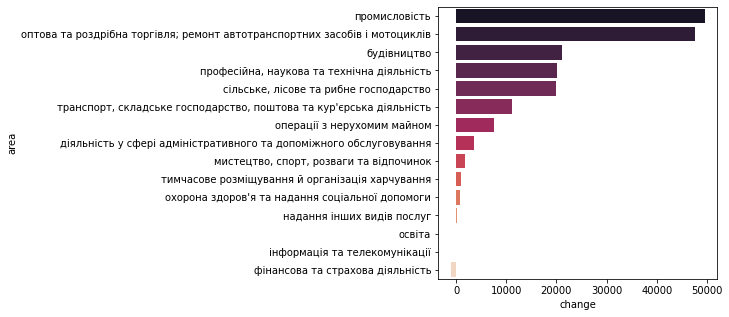

In [8]:
change_df = pd.DataFrame(data=df.total_1 - df.total_0, columns=['change'])\
    .sort_values('change', ascending=False)

plt.figure(figsize=(5, 5))
sns.barplot(
    x=change_df.change,
    y=change_df.index,
    palette='rocket'
)
plt.show()

### Check for empty values

In [9]:
df.isnull().sum()

total_0      0
total_1      0
stocks_0     0
stocks_1     0
biology_0    0
biology_1    0
debt_0       0
debt_1       0
invest_0     0
invest_1     0
funds_0      0
funds_1      0
spends_0     0
spends_1     0
other_0      0
other_1      0
dtype: int64

### Check all areas values

In [10]:
[*df.index]

['сільське, лісове та рибне господарство',
 'промисловість',
 'будівництво',
 'оптова та роздрібна торгівля; ремонт автотранспортних засобів і мотоциклів',
 "транспорт, складське господарство, поштова та кур'єрська діяльність",
 'тимчасове розміщування й організація харчування',
 'інформація та телекомунікації',
 'фінансова та страхова діяльність',
 'операції з нерухомим майном',
 'професійна, наукова та технічна діяльність',
 'діяльність у сфері адміністративного та допоміжного обслуговування',
 'освіта',
 "охорона здоров'я та надання соціальної допомоги",
 'мистецтво, спорт, розваги та відпочинок',
 'надання інших видів послуг']

### Check for negative currency values 

In [11]:
(df < 0).astype(int).sum(axis=0)

total_0      0
total_1      0
stocks_0     0
stocks_1     0
biology_0    0
biology_1    0
debt_0       0
debt_1       0
invest_0     0
invest_1     0
funds_0      0
funds_1      0
spends_0     0
spends_1     0
other_0      0
other_1      0
dtype: int64

## Hierarchical clustering

### Visualize data

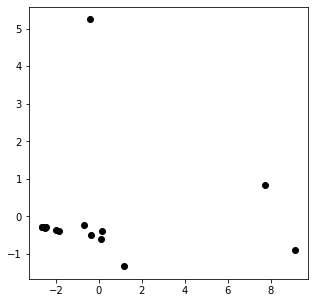

In [12]:
scaler = preprocessing.StandardScaler()
norm_df = scaler.fit_transform(df)

pca = decomposition.PCA(n_components=2, random_state=4)
x, y = pca.fit_transform(norm_df).T

plt.figure(figsize=(5, 5))
plt.scatter(x, y, color='black')
plt.show()

## Compute distances

In [13]:
metrics = ['euclidean', 'seuclidean', 'chebyshev']
n_metrics = len(metrics)

In [14]:
dist_dict = {}
for metric in metrics:
    dist_dict[metric] = distance.pdist(norm_df, metric)

In [15]:
dist_dict

{'euclidean': array([ 9.89955527,  5.89853474, 11.3598286 ,  5.88541916,  6.08413453,
         5.97843032,  6.97289257,  5.90432157,  5.93451381,  6.00133333,
         6.14165566,  6.12791884,  6.09013678,  6.13871558,  8.07888745,
         4.17103499,  8.77402255, 10.49016113, 10.04312723,  8.54550122,
         8.6206535 ,  8.30838337,  9.96587321, 10.66794627, 10.62588594,
        10.50784571, 10.66089636,  9.1707213 ,  2.1646589 ,  2.8071115 ,
         2.42953659,  3.46845816,  1.05680704,  1.75542324,  2.22061017,
         2.99527581,  2.95369896,  2.78884576,  2.98541276, 10.10296182,
        11.73393482, 11.22964215,  8.24746093,  9.61731908,  9.11932952,
        11.09300295, 11.91645444, 11.87458055, 11.73829254, 11.90921731,
         2.20194526,  1.64849464,  4.16303469,  1.52749319,  1.97944938,
         1.94134365,  2.3569169 ,  2.31854756,  2.22260492,  2.3571111 ,
         0.61269886,  4.87685979,  2.26895055,  2.84402192,  0.85407794,
         0.19810366,  0.1538489 ,  0.1

## Clusterize data and compute cophenet

In [16]:
methods = ['average', 'centroid', 'median']
n_methods = len(methods)

In [17]:
cophenets = np.zeros((n_metrics, n_methods))
clustereds = defaultdict(dict)

for dist_idx, (metric, dist) in enumerate(dist_dict.items()):
    for method_idx, method in enumerate(methods):
        
        clustered = hierarchy.linkage(dist, method)
        cophenet = hierarchy.cophenet(clustered, dist)[0]
        
        clustereds[metric][method] = clustered
        cophenets[dist_idx][method_idx] = cophenet

cophenet_df = pd.DataFrame(cophenets, metrics, methods)

In [18]:
cophenet_df

,average,centroid,median
euclidean,0.981662,0.981498,0.979090
seuclidean,0.981662,0.981498,0.979090
chebyshev,0.988820,0.983404,0.984053


## Find best and worst metric and method

In [19]:
pd.DataFrame([cophenet_df.idxmin(), cophenet_df.min()])

,average,centroid,median
0,euclidean,seuclidean,euclidean
1,0.981662,0.981498,0.97909


In [20]:
pd.DataFrame([cophenet_df.idxmax(), cophenet_df.max()])

,average,centroid,median
0,chebyshev,chebyshev,chebyshev
1,0.98882,0.983404,0.984053


In [21]:
best_metric = 'chebyshev'
best_method = 'average'
best_clustered = clustereds[best_metric][best_method]

## Dengdrogram

In [22]:
def pretty_dendrogram(*args, **kwargs):
    annotate_above = kwargs.pop('annotate_above', 0)
    max_d = kwargs.pop('max_d', 0)
    if max_d and 'color_threshold' not in kwargs:
        kwargs['color_threshold'] = max_d
        
    ddata = hierarchy.dendrogram(*args, **kwargs, orientation='right')
    
    if max_d: plt.axvline(max_d)
    
    for i, d, c in zip(ddata['icoord'], ddata['dcoord'], ddata['color_list']):
        y = 0.5 * sum(i[1:3])
        x = d[1]
        if y > annotate_above:
            plt.plot(x, y, 'o', c=c)
            plt.annotate('%.3g' % y, (x, y), xytext=(0, -5),
                         textcoords='offset points',
                         va='top', ha='center')
        
    return ddata

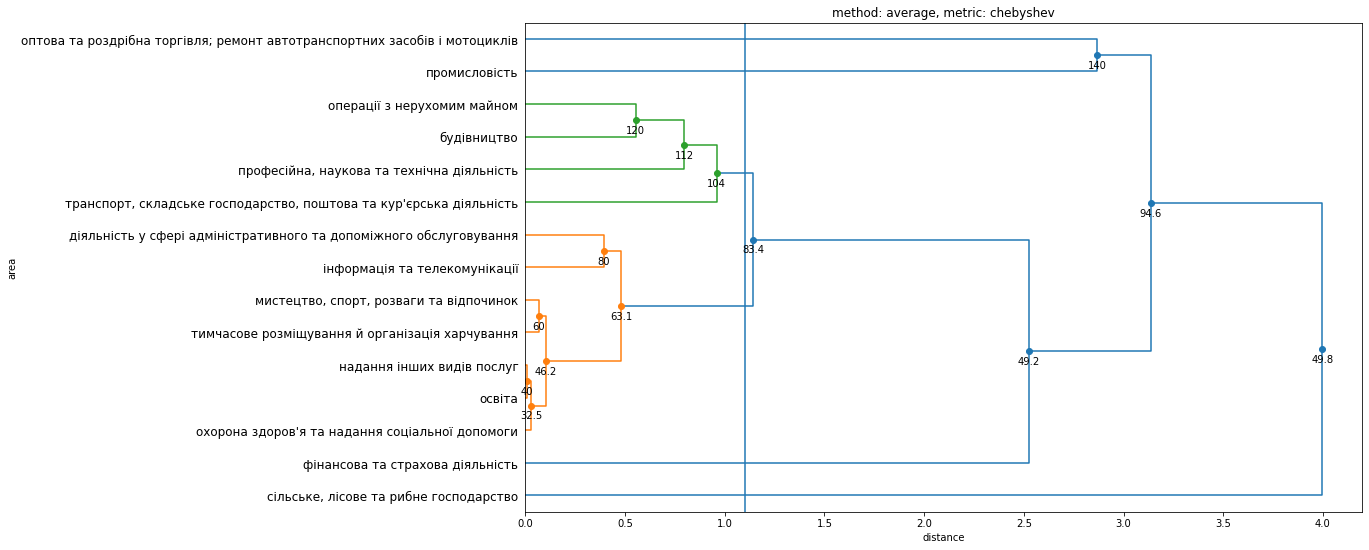

In [23]:
plt.figure(figsize=(15, 9))
plt.title(f'method: {best_method}, metric: {best_metric}')
plt.xlabel('distance')
plt.ylabel('area')
        
pretty_dendrogram(
    Z=best_clustered,
    labels=df.index,
    max_d=1.1
)

plt.show()

# Determine number of clusters

In [24]:
def plot_clusters_method(x: np.ndarray, y: np.ndarray, ylabel: str) -> None:
    plt.figure(figsize=(8, 8))
    plt.xlabel('Clusters number')
    plt.ylabel(ylabel)
    plt.plot(x, y, '-ro')

### Silhouette score

In [25]:
def silhouette(clustered: np.ndarray, min_clusters: int = 2, max_clusters: int = 15) -> np.ndarray:
    n_clusters = np.arange(min_clusters, max_clusters)
    scores = np.zeros(n_clusters.size)
    dist_matrix = distance.squareform(dist_dict[best_metric])

    for idx, num in enumerate(n_clusters):
        targets = hierarchy.fcluster(clustered, num, criterion='maxclust')
        score = silhouette_score(dist_matrix, labels=targets)
        scores[idx] = score
    
    plot_clusters_method(n_clusters, scores, 'Silhouette score')

    return scores

array([0.50365358, 0.55770888, 0.50957607, 0.51330365, 0.46036508,
       0.39858095, 0.33389276, 0.31324358, 0.32689641, 0.26937955,
       0.21562792, 0.15658858, 0.15658858])

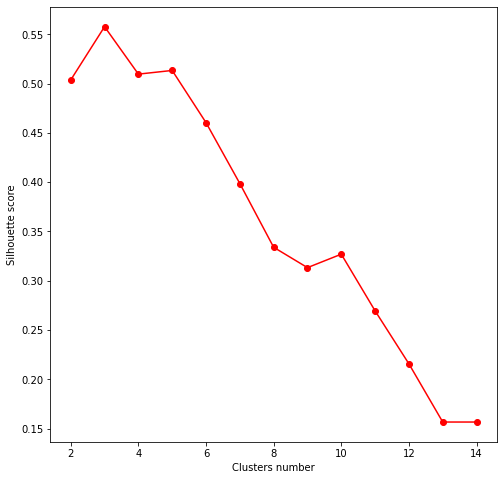

In [26]:
silhouette(best_clustered)

### Elbow method

In [27]:
def elbow(clustered: np.ndarray, min_clusters: int = 1, max_clusters: int = 15) -> np.ndarray:
    n_clusters = np.arange(min_clusters, max_clusters)
    inertias = np.zeros_like(n_clusters)
    
    for idx, num in enumerate(n_clusters):
        targets = hierarchy.fcluster(clustered, num, 'maxclust')
        result = pd.DataFrame(norm_df)
        result['target'] = targets
        
        centroids = result.groupby('target').agg(np.mean).values
        inertia = np.square(norm_df - centroids[targets - 1]).sum()
        inertias[idx] = inertia
    
    plot_clusters_method(n_clusters, inertias, 'Inertia')
    
    return inertias

array([240, 209,  42,  34,  18,   5,   3,   1,   1,   0,   0,   0,   0,
         0])

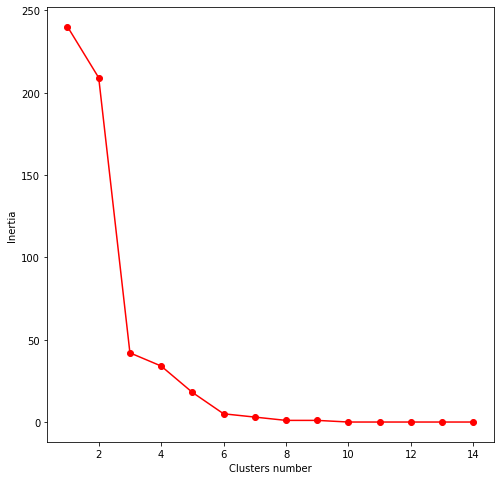

In [28]:
elbow(best_clustered)

## Split on clusters

In [29]:
n_clusters = 6

In [30]:
targets = hierarchy.fcluster(
    Z=best_clustered,
    t=n_clusters,
    criterion='maxclust'
)

In [31]:
target_df = pd.DataFrame(norm_df, columns=df.columns)
target_df['target'] = targets

## Find centeroids and distances between them

### Centroids

In [32]:
centroids = target_df.groupby('target').agg(np.mean).values
centroids

array([[-0.66492667, -0.66935991, -0.67741149, -0.6528678 , -0.30361402,
        -0.29870236, -0.6221982 , -0.64108899, -0.56732902, -0.57149817,
        -0.70456072, -0.70050608, -0.57077531, -0.53886115, -0.68060751,
        -0.68807939],
       [-0.10619685, -0.09072074, -0.18599059, -0.20734855, -0.29957444,
        -0.29306682, -0.09998269, -0.06349991, -0.02010336, -0.00907087,
         0.07339613,  0.03256618, -0.03765938, -0.11741175,  0.03111858,
         0.04914124],
       [ 0.33954967,  0.27485385,  0.6063741 ,  0.33410915, -0.30373662,
        -0.29883795, -0.0144873 , -0.01571178,  2.12566599,  2.15591043,
         0.25695453,  0.31113018, -0.50096482, -0.45295078,  0.03954475,
        -0.00760784],
       [ 2.22716313,  2.24144929,  2.56610373,  2.61684251,  0.04918179,
         0.0690231 ,  2.30726037,  2.29666494, -0.17233524, -0.15881218,
         2.20167658,  2.22276699,  2.5037539 ,  2.39841311,  2.20076387,
         2.36759686],
       [ 2.57718067,  2.56596794,  2

### Distance between centroids

In [33]:
distance.pdist(centroids)

array([ 2.22791902,  4.78706223, 10.41911903, 11.63961853,  6.06765378,
        3.31606519,  8.38418207,  9.45262139,  5.81144515,  8.54550122,
        8.24746093,  6.97289257,  4.17103499,  9.89955527, 11.3598286 ])

## Visualize clustered data

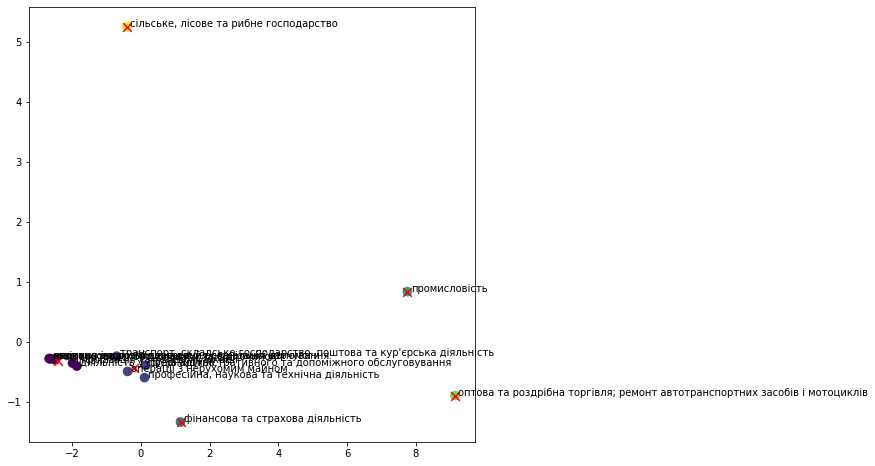

In [36]:
target2d = pd.DataFrame({'x': x, 'y': y, 'target': targets})

plt.figure(figsize=(8, 8))
plt.scatter(x, y, c=targets, s=75)

for idx, label in enumerate(df.index):
    plt.annotate(
        text=label, 
        xy=(x[idx] + 0.1, y[idx])
    )

plt.scatter(
    x='x', y='y', s=75, 
    color='r', 
    marker='x', 
    data=target2d.groupby('target').agg('mean')
)
plt.show()